In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyxdf

%matplotlib inline

# Analyze screen flicker delay/jitter

## Load lsl recording

In [3]:
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-Default_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-001_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-002_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_run-005_eeg.xdf'
fpath = 'results\sub-P001\ses-S001\eeg\sub-P001_ses-S001_task-vsync_test_psychopy_run-001_eeg.xdf'
fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
# fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg_old1.xdf'
# fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-slow_erp_test_run-003_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_slow_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-pyglet_fast_erp_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new-monitor-test_run-001_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-new_monitor_test_run-002_eeg.xdf"
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_timing_accuracy_test_run-003_eeg.xdf"
fpath = 'C:/Users/Experiment/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf'
fpath = "../../CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_flip_timing_test-001_eeg.xdf"
fpath = "C:/Users/Experiment/Documents/BCI/AmarE/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-screen_flip_timing_test_run-001_eeg.xdf"
fpath = "C:/Users/Experiment/Documents/BCI/AmarE/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-7m_cable_test_run-001_eeg.xdf"
streams, header = pyxdf.load_xdf(fpath, dejitter_timestamps=False)

for stream in streams:
    print(stream['info']['name'])

['ScreenSensorStream']
['ScreenSequenceStream']


In [4]:
# Load timestamps
sequence_stream = [s for s in streams if s['info']['name'][0] == 'ScreenSequenceStream'][0]
sensor_stream = [s for s in streams if s['info']['name'][0] == 'ScreenSensorStream'][0]
# marker_stream = [s for s in streams if s['info']['name'][0] == 'MarkerStream'][0]

In [5]:
np.unique(sequence_stream['time_series'])

array(['0', '1', 'Start', 'end'], dtype='<U5')

In [6]:
timestamps = sequence_stream['time_stamps']
timestamps_sensor = sensor_stream['time_stamps']
print('LSL Timestamps:', timestamps.shape)
print('Sensor timestamps', timestamps_sensor.shape)

# Start from start marker
marker_timeseries = np.array(sequence_stream['time_series']).ravel()
marker_timestamps = sequence_stream['time_stamps']
start_timestamp = marker_timestamps[marker_timeseries == 'Start'][0]
end_timestamp = marker_timestamps[marker_timeseries == 'end'][0]

timestamps = timestamps[timestamps > start_timestamp]
timestamps = timestamps[timestamps < end_timestamp]
timestamps_sensor = timestamps_sensor[timestamps_sensor > start_timestamp]
timestamps_sensor = timestamps_sensor[timestamps_sensor < end_timestamp]
timestamps = timestamps - start_timestamp
timestamps_sensor = timestamps_sensor - start_timestamp
print('LSL Timestamps:', timestamps.shape)
print('Sensor timestamps', timestamps_sensor.shape)

%matplotlib qt
plt.scatter(timestamps, np.ones_like(timestamps), label='expected', marker='o')
plt.scatter(timestamps_sensor, np.ones_like(timestamps_sensor), label='actual', marker='x')
plt.legend()
plt.show()


LSL Timestamps: (2002,)
Sensor timestamps (6632,)
LSL Timestamps: (2000,)
Sensor timestamps (6632,)


In [7]:
# Remove sensor jitter
def remove_jitter(timestamps, tolerance=0.001):
    filtered = [timestamps[0]]
    # print(filtered)
    for timestamp in timestamps[1:]:
        if timestamp - filtered[-1] >= tolerance:
            filtered.append(timestamp)
    return np.array(filtered)

timestamps_sensor_filtered = remove_jitter(timestamps_sensor)

print('LSL Timestamps:', timestamps.shape)
print('Sensor timestamps', timestamps_sensor_filtered.shape)

plt.scatter(timestamps, np.ones_like(timestamps), label='expected', marker='o')
plt.scatter(timestamps_sensor_filtered, np.ones_like(timestamps_sensor_filtered), label='actual', marker='x')
plt.legend()
plt.show()

LSL Timestamps: (2000,)
Sensor timestamps (2002,)


In [8]:
np.unique((np.diff(timestamps) * 1000).astype(int), return_counts=True)

(array([ 99, 100, 133, 159, 416]),
 array([346, 653, 916,   1,  83], dtype=int64))

In [9]:
# Filter sensor jitter
df_timestamps = pd.DataFrame(timestamps, columns=['timestamp'])
df_timestamps_sensor = pd.DataFrame(timestamps_sensor_filtered, columns=['timestamp_sensor'])

df_merged = pd.merge_asof(df_timestamps, df_timestamps_sensor, left_on='timestamp', right_on='timestamp_sensor', direction='nearest', tolerance=0.1)
print(df_merged.shape)
print(df_merged.head())
print('\n# of NaNs:')
print(df_merged.isna().sum())

(2000, 2)
   timestamp  timestamp_sensor
0   1.016165          1.046479
1   1.176059          1.179017
2   1.309279          1.313161
3   1.409379          1.412398
4   1.542711          1.546638

# of NaNs:
timestamp           0
timestamp_sensor    0
dtype: int64


In [10]:
%matplotlib qt

plt.scatter(df_merged['timestamp'], np.ones_like(df_merged['timestamp']), label='expected', marker='o')
plt.scatter(df_merged['timestamp_sensor'], np.ones_like(df_merged['timestamp_sensor']), label='actual', marker='x')
plt.legend()
plt.show()

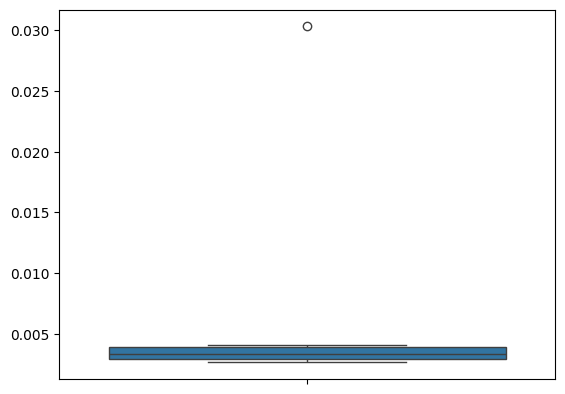

In [11]:
%matplotlib inline
plt.clf()
plt.cla()
sns.boxplot(df_merged['timestamp_sensor'] - df_merged['timestamp'])
plt.show()


Shape before: (2000, 2)
Shape after: (2000, 2)

# of NaNs:
timestamp           32
timestamp_sensor    32
dtype: int64


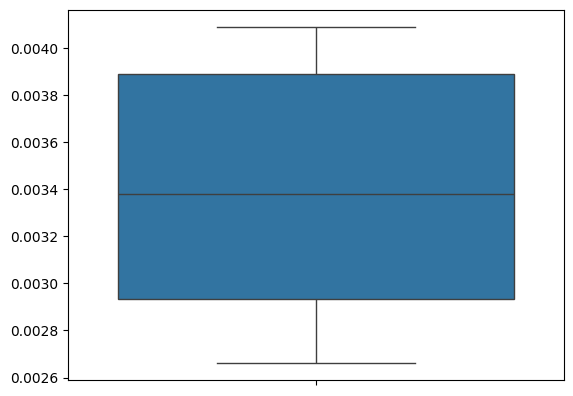

In [13]:
# Ignore first N seconds
start_time = 5
print('Shape before:', df_merged.shape)
df_merged['timestamp'] = df_merged['timestamp'].where(df_merged['timestamp'] > start_time)
df_merged['timestamp_sensor'] = df_merged['timestamp_sensor'].where(df_merged['timestamp_sensor'] > start_time)
print('Shape after:', df_merged.shape)
print('\n# of NaNs:')
print(df_merged.isna().sum())

sns.boxplot(df_merged['timestamp_sensor'] - df_merged['timestamp'], showfliers=False)
plt.show()